In [5]:
import xarray as xr
import numpy as np


In [9]:
def create_numpy_dataset(file_name_moorings, file_name_umo, temporal_resample = None):
    
    ## Loading the mooring data to create a numpy array out of it.
    ds_pos = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/{file_name_moorings}.nc')

    ds_pos = ds_pos.resample(time = temporal_resample).mean()
    numpy_values = ds_pos.rho.sel(pos = ['west', 'marwest', 'mareast', 'east']).stack(feature=('pos', 'z')).fillna(0).data
    numpy_time = ds_pos.time.data
    numpy_z = ds_pos.z.data

    t_umo = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/{file_name_umo}.nc').resample(time = temporal_resample).mean()
    numpy_umo = t_umo.sel(time = ds_pos.time, method='nearest').dv_dz_times_X.data
    np.savez(f'../rapid-geostrophic-reconstruction/data/learning/{file_name_moorings}_{file_name_umo}_{temporal_resample}.npz', numpy_values=numpy_values, numpy_time=numpy_time, numpy_z=numpy_z, numpy_umo=numpy_umo)


In [12]:
create_numpy_dataset('ds_pos_obs_std', 't_umo_obs', temporal_resample='10D')
create_numpy_dataset('ds_pos_sim_miss_std', 't_umo_sim_miss', temporal_resample='10D')

## ARGO dataset

In [1]:
import xarray as xr
file_name_moorings = 'ds_pos_obs'
ds_pos_obs = xr.open_dataset(f'../rapid-geostrophic-reconstruction/data/{file_name_moorings}.nc')

In [2]:
from pathlib import Path

path = Path('data/raw/argo_25N_30N_10W_81W_alldepth_alltime/')
list_of_files = list(path.glob('GL_PR_PF_*.nc'))

In [3]:
import gsw
def add_ct_and_rho(ds_pos):

    ds_pos["ct"] = gsw.conversions.CT_from_t(ds_pos.salinity, ds_pos.temperature, ds_pos.pressure)
    ds_pos["ct"].attrs["long_name"] = "Conservative Temperature"
    ds_pos["ct"].attrs["units"] = "degC"
    
    ds_pos["rho"] = gsw.density.rho(ds_pos.salinity, ds_pos.ct, ds_pos.pressure)
    ds_pos["rho"].attrs["long_name"] = "Density"
    ds_pos["rho"].attrs["units"] = "kg/m3"
    
    return ds_pos

In [6]:
time_smooting = '30D'

times = []

for file in list_of_files:
    ds = xr.open_dataset(file)

    ds["TIME"] = ds.TIME.dt.floor(time_smooting)
    

    times.append(ds.TIME.data)


unique_times, counts = np.unique(np.concatenate(times), return_counts=True)
max_count = counts.max()
times_pos_dict = {t: 0 for t in unique_times}

empty_temperature = np.full((len(unique_times), ds_pos_obs.z.shape[0], max_count), np.nan)
empty_salinity = np.full((len(unique_times), ds_pos_obs.z.shape[0], max_count), np.nan)

empty_lon = np.full((len(unique_times), max_count), np.nan)
empty_lat = np.full((len(unique_times), max_count), np.nan)

profile_mask = np.zeros((len(unique_times), max_count))


for f_i, f_name in enumerate(list_of_files[:]):

    print(f"{f_i:03d}/{len(list_of_files)}: {f_name}")


    ds_argo = xr.open_dataset(f_name)
    ds_argo["TIME"] = ds_argo.TIME.dt.floor(time_smooting)
    ds_argo = ds_argo.assign_coords(PRES = ds_argo.PRES)

    if 'PSAL' not in ds_argo or 'TEMP' not in ds_argo or 'PRES' not in ds_argo \
        or 'TEMP_QC' not in ds_argo or 'PSAL_QC' not in ds_argo or 'PRES_QC' not in ds_argo:
        continue


    times = []
    temp_profiles = []
    sal_profiles = []

    valid_times_indices = []


    for t_i in range(ds_argo.TIME.shape[0]):

        if ds_argo.POSITION_QC.isel(POSITION = t_i) != 1:
            continue

        ds_argo_ti = ds_argo.isel(TIME = t_i)


        # check for quality constraints

        only_depth_with_all_values = (ds_argo_ti.PRES_QC == 1) & (ds_argo_ti.TEMP_QC == 1) & (ds_argo_ti.PSAL_QC == 1)

        # are there more than 10 values between the surface and 2000m?
        if ds_argo_ti.PRES.where(only_depth_with_all_values & (ds_argo_ti.PRES < 2000)).count() < 10:
            continue

        # are there at least 2 profiles in the top 100m?
        if ds_argo_ti.PRES.where(only_depth_with_all_values & (ds_argo_ti.PRES < 100)).count() < 2:
            continue


        # interpolate temperature and salinity on the observational mooring `ds_pos_obs` grid

        def interpolate_feature_onto_mooring_depth(argo_array, argo_feature_string):
            interpolated = argo_array[argo_feature_string] \
                .where(only_depth_with_all_values) \
                .assign_coords(DEPTH = argo_array.PRES) \
                .dropna('DEPTH') \
                .interp(
                    DEPTH = ds_pos_obs.pressure,
                    method="slinear",
                    kwargs={"fill_value": "extrapolate"},
                )
            
            interpolated = interpolated.where( # cutting the extrapolated profile in the original depth
                interpolated.DEPTH <= argo_array.PRES.where(only_depth_with_all_values, drop = True).max()
            )

            return interpolated

        interpolated_TEMP = interpolate_feature_onto_mooring_depth(ds_argo_ti, 'TEMP')
        interpolated_PSAL = interpolate_feature_onto_mooring_depth(ds_argo_ti, 'PSAL')

        temp_profiles.append(interpolated_TEMP.data)
        sal_profiles.append(interpolated_PSAL.data)
        times.append(ds_argo_ti.TIME.data[()])
        valid_times_indices.append(t_i)

        time_index = np.argwhere(unique_times == ds_argo_ti.TIME.data).squeeze()[()]
        empty_temperature[time_index, :, times_pos_dict[times[-1]]] = interpolated_TEMP.data
        empty_salinity[time_index, :, times_pos_dict[times[-1]]] = interpolated_PSAL.data

        empty_lon[time_index, times_pos_dict[times[-1]]] = ds_argo.LONGITUDE.isel(LONGITUDE = t_i).data
        empty_lat[time_index, times_pos_dict[times[-1]]] = ds_argo.LATITUDE.isel(LATITUDE = t_i).data

        profile_mask[time_index, times_pos_dict[times[-1]]] = 1

        times_pos_dict[times[-1]] += 1

    

ds_argo_merged = xr.Dataset(
    {
        "temperature": (("time", "z", "pos"), empty_temperature),
        "salinity": (("time", "z", "pos"), empty_salinity),
        "profile_mask": (("time", "pos"), profile_mask),
    },
    coords = {
        "time": unique_times,
        "z": ds_pos_obs.z.data,
        "pressure": ('z', ds_pos_obs.pressure.data),
        "lon": (('time', 'pos'), empty_lon),
        "lat": (('time', 'pos'), empty_lat),
        "pos": np.arange(max_count)
    }
)

ds_argo_merged = ds_argo_merged.where(ds_argo_merged.profile_mask >= 1, drop=True)

ds_argo_merged = add_ct_and_rho(ds_argo_merged)


000/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_6900935.nc


/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


001/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_5904015.nc
002/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_6901258.nc
003/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_4900208.nc
004/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_6900512.nc
005/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_4902345.nc
006/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_4900471.nc
007/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_4903256.nc
008/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_6900113.nc
009/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_4903341.nc
010/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_4903487.nc
011/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_6900910.nc
012/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_6901915.nc
013/513: data/raw/argo_25N_30N_10W_81W_alldepth_alltime/GL_PR_PF_6900412.nc
014/513: dat

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in ct_from_t
  result_data = func(*input_data)


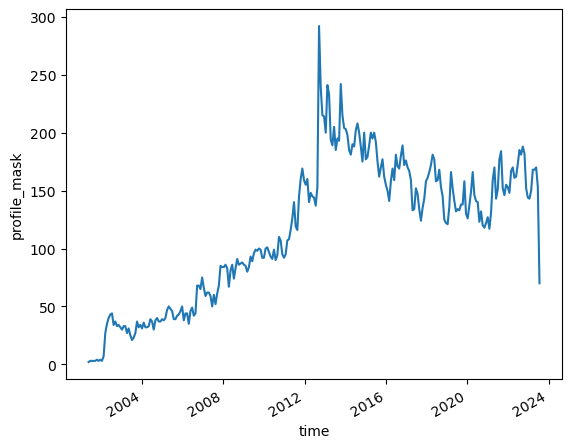

In [8]:
ds_argo_merged.profile_mask.sum('pos').plot()

In [9]:
ds_pos_obs.resample(time = '30D').mean()

<xarray.Dataset>
Dimensions:      (z: 242, pos: 5, time: 218)
Coordinates:
    pressure     (z) float64 0.0 20.0 40.0 60.0 ... 4.78e+03 4.8e+03 4.82e+03
  * z            (z) float64 -0.0 -20.0 -40.0 ... -4.78e+03 -4.8e+03 -4.82e+03
  * pos          (pos) object 'west' 'wb3' 'marwest' 'mareast' 'east'
    name         (pos) object 'west' 'wb3' 'marwest' 'mareast' 'east'
    lon          (pos) float64 -76.74 -76.5 -50.57 -41.21 -16.23
    lat          (pos) float64 26.52 26.5 24.52 24.52 26.99
  * time         (time) datetime64[ns] 2004-04-02 2004-05-02 ... 2022-01-28
Data variables:
    temperature  (time, pos, z) float64 nan nan nan nan ... 2.4 2.402 2.404
    salinity     (time, pos, z) float64 nan nan nan nan ... 34.89 34.89 34.89
    ct           (time, pos, z) float64 nan nan nan nan ... 2.399 2.401 2.403
    rho          (time, pos, z) float64 nan nan nan ... 1.049e+03 1.049e+03
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...
    long_name:                     Temperature
    units:                         degC

In [10]:
from copy import deepcopy
rho_std_argo = ds_argo_merged.rho.std(["pos", "time", "z"]).data[()]
rho_mean_argo = ds_argo_merged.rho.mean(["pos", "time"])


def standardize_rho(ds_pos, rho_mean=None, rho_std=None):
    ds_pos = deepcopy(ds_pos)
    ds_pos["rho"] = (ds_pos["rho"] - rho_mean) / rho_std
    return ds_pos

ds_argo_merged_std = standardize_rho(
    ds_argo_merged,
    rho_mean=rho_mean_argo,  # 👀 !!
    rho_std=rho_std_argo,
)

In [11]:
ds_argo_merged.to_netcdf(f'../rapid-geostrophic-reconstruction/data/ds_argo_{time_smooting}.nc')
ds_argo_merged_std.to_netcdf(f'../rapid-geostrophic-reconstruction/data/ds_argo_{time_smooting}_std.nc')
